In [1]:
from tqdm import tqdm
import requests
import pandas as pd
import numpy as np

from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPool1D

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import imblearn

/home/milosevicn/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
2022-10-18 12:13:37.235487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
assays = [
    "ATG_PPARg_TRANS_dn", 
    "ATG_PPARg_TRANS_up", 
    "TOX21_PPARg_BLA_antagonist_ratio", 
    "TOX21_PPARg_BLA_Agonist_ratio", 
    "NVS_NR_hPPARg", 
    "ERF_ENZ_hCYP19A1_dn", 
    "NVS_ADME_hCYP19A1", 
    "NVS_ADME_hCYP19A1_Activator", 
    "TOX21_Aromatase_Inhibition", 
    "CEETOX_H295R_ESTRADIOL_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_dn", 
    "CEETOX_H295R_ESTRADIOL_noMTC_up", 
    "CEETOX_H295R_ESTRADIOL_up", 
    "CEETOX_H295R_ESTRONE_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_dn", 
    "CEETOX_H295R_ESTRONE_noMTC_up", 
    "CEETOX_H295R_ESTRONE_up"
]

In [3]:
# find all matching

dfs = []
smiles = []

for assay in assays:
    path = f"data/{assay}.csv"
    df = pd.read_csv(path)
    # print(df["smiles"].isnull().sum())
    
    s = df[["preferredName", "smiles"]].copy()
    s.index = s["preferredName"]
    del s["preferredName"]
    smiles.append(s)
    
    df = df[["preferredName", "hitc"]] # only leave these two columns
    
    df = df[df["hitc"] != -1] # 22.9.2022.: remove inconclusive results
    
    df.index = df["preferredName"] 
    del df["preferredName"] # set index to name and remove the column name
    df.columns = [assay] # set type (only remaining column) to name of assay
    # df.dropna(inplace=True)  # TODO: search for names in some other way?
    
    dfs.append(df)
    
# save for later
smiles = pd.concat(smiles, axis=0)
smiles = smiles[~smiles.index.duplicated(keep='first')]

In [4]:
smiles.isnull().sum() # should be zero, run fix-smiles!

smiles    0
dtype: int64

# SAC (single assay experiments) full experiment and export

Training for ATG_PPARg_TRANS_dn
Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:13:42] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:13:42] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:13:42] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:13:42] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
RDKit ERROR: [12:13:43] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:13:43] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-

Bad smiles string for Dinocap
Bad smiles string for 4-Nonylphenol, branched


RDKit ERROR: [12:13:43] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:13:43] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:13:43] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:13:43] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:13:43] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:13:43] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'


Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese


RDKit ERROR: [12:13:43] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:13:43] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:13:43] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:13:43] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:13:43] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:13:43] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:13:43] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:13:43] Explicit valence for atom # 3 Si, 8, is greater than permitted


Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate
ok: 3594
bad: ['Calcium dodecylbenzene sulfonate', 'Dinocap', '4-Nonylphenol, branched', 'Zinc pyrithione', 'Diisooctyl adipate', '(Methylcyclopentadienyl)tricarbonylmanganese', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 8


2022-10-18 12:13:45.392753: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-18 12:13:45.393791: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-18 12:13:45.860469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 12:13:45.860646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-10-18 12:13:45.860672: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-18 12:13:45.863435: I tensorflow/stream_executor/platf

Epoch 1/25


2022-10-18 12:13:46.763346: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-18 12:13:46.915985: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


179/179 [==============================] - 4s 17ms/step - loss: 0.9709 - accuracy: 0.4943 - val_loss: 0.6302 - val_accuracy: 0.5880
Epoch 2/25
179/179 [==============================] - 3s 14ms/step - loss: 0.6911 - accuracy: 0.7079 - val_loss: 0.6064 - val_accuracy: 0.7046
Epoch 3/25
179/179 [==============================] - 3s 15ms/step - loss: 0.3211 - accuracy: 0.8953 - val_loss: 0.1900 - val_accuracy: 0.9169
Epoch 4/25
179/179 [==============================] - 3s 14ms/step - loss: 0.1330 - accuracy: 0.9631 - val_loss: 0.0555 - val_accuracy: 0.9888
Epoch 5/25
179/179 [==============================] - 3s 14ms/step - loss: 0.0814 - accuracy: 0.9787 - val_loss: 0.0275 - val_accuracy: 0.9923
Epoch 6/25
179/179 [==============================] - 3s 14ms/step - loss: 0.0390 - accuracy: 0.9898 - val_loss: 0.0340 - val_accuracy: 0.9874
Epoch 7/25
179/179 [==============================] - 3s 14ms/step - loss: 0.0303 - accuracy: 0.9925 - val_loss: 0.0173 - val_accuracy: 0.9944
Epoch 8/25

2022-10-18 12:14:51.864280: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved ATG_PPARg_TRANS_dn
Training for ATG_PPARg_TRANS_up
Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:14:53] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:14:53] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:14:53] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:14:53] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
RDKit ERROR: [12:14:53] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:14:53] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+

Bad smiles string for Dinocap
Bad smiles string for 4-Nonylphenol, branched


RDKit ERROR: [12:14:53] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:14:53] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:14:53] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:14:53] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:14:53] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:14:53] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
RDKit ERROR: [12:14:54] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:14:54] Explicit valence for atom # 4 C, 5, is greater than permitted


Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese


RDKit ERROR: [12:14:54] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:14:54] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:14:54] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:14:54] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:14:54] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:14:54] Explicit valence for atom # 3 Si, 8, is greater than permitted


Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate
ok: 3594
bad: ['Calcium dodecylbenzene sulfonate', 'Dinocap', '4-Nonylphenol, branched', 'Zinc pyrithione', 'Diisooctyl adipate', '(Methylcyclopentadienyl)tricarbonylmanganese', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 8
Epoch 1/25
129/129 [==============================] - 2s 15ms/step - loss: 0.9789 - accuracy: 0.4987 - val_loss: 0.7083 - val_accuracy: 0.5262
Epoch 2/25
129/129 [==============================] - 2s 14ms/step - loss: 0.9415 - accuracy: 0.4896 - val_loss: 0.7230 - val_accuracy: 0.5262
Epoch 3/25
129/129 [==============================] - 2s 14ms/step - loss: 0.9190 - accuracy: 0.4891 - val_loss: 0.6805 - val_accuracy: 0.5465
Epoch 4/25
129/129 [==============================] - 2s 14ms/step - loss: 0.8996 - accuracy: 0.5261 - val_loss: 0.6826 - val_accuracy: 0.5921
Epoch 5/25
129/129 [==============================] - 2s 14ms/step - loss: 0.8637 - accurac

2022-10-18 12:15:42.253626: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved ATG_PPARg_TRANS_up
Training for TOX21_PPARg_BLA_antagonist_ratio
Bad smiles string for Diisopropylbenzene


RDKit ERROR: [12:15:43] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[12:15:43] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [12:15:43] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
[12:15:43] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
RDKit ERROR: [12:15:43] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:15:43] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:15:43] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:15:43] SMILES Parse Error: Failed 

Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:15:44] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:15:44] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:15:44] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:15:44] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:15:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:15:44] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:15:44] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:15:44] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:15:44] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:15:44] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:15:44] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:15:44] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'


Bad smiles string for 4-Nonylphenol, branched


RDKit ERROR: [12:15:44] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:15:44] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:15:44] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:15:44] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:15:44] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:15:44] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:15:44] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:15:44] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
RDKit ERROR: [12:15:45] Explicit valence for atom # 1 C, 5, is greater than permitted
[12:15:45] Explicit valence for atom # 1 C, 5, is greater than permi

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:15:45] WARNING: not removing hydrogen atom without neighbors
[12:15:45] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:15:45] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:15:45] Explicit valence for atom # 0 F, 2, is greater than permitted
RDKit ERROR: [12:15:45] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:15:45] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:15:45] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:15:45] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:15:45] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:15:45] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:15:45] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:15:45] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
[12:15:45] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:15:45] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:15:45] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:15:45] Explicit valence for atom # 3 Si, 8, is greater than permitted


ok: 7335
bad: ['Diisopropylbenzene', 'Calcium dodecylbenzene sulfonate', 'Dinocap', 'Carboplatin', 'Cisplatin', '4-Nonylphenol, branched', 'Magnesium, bis(salicylato)-, tetrahydrate', 'Zinc pyrithione', 'Diisooctyl adipate', 'Vitamin B12', '1-Ethyl-1-methylpyrrolidinium tetrafluoroborate', '(Methylcyclopentadienyl)tricarbonylmanganese', '1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 15
Epoch 1/25
324/324 [==============================] - 5s 15ms/step - loss: 0.9720 - accuracy: 0.5030 - val_loss: 0.7205 - val_accuracy: 0.4954
Epoch 2/25
324/324 [==============================] - 5s 14ms/step - loss: 0.9170 - accuracy: 0.5065 - val_loss: 0.6349 - val_accuracy: 0.6557
Epoch 3/25
324/324 [==============================] - 5s 14ms/step - loss: 0.8592 - accuracy: 0.6051 - val_loss: 0.6053 - val_accuracy: 0.6754
Epoch 4/25
324/324 [==============================] - 5s 14ms/step - loss: 0.8002 - accuracy

2022-10-18 12:17:44.464358: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved TOX21_PPARg_BLA_antagonist_ratio
Training for TOX21_PPARg_BLA_Agonist_ratio
Bad smiles string for Diisopropylbenzene
Bad smiles string for Gentamicin sulfate


RDKit ERROR: [12:17:45] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[12:17:45] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [12:17:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
[12:17:45] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
RDKit ERROR: [12:17:45] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1
RDKit ERROR: [12:17:45] SMILES Parse Error: Failed parsing SMILES '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1' for input: '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1'
[12:17:45] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(

Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:17:46] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:17:46] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:17:46] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:17:46] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:17:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:17:46] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:17:46] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:17:46] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:17:46] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:17:46] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:17:46] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
RDKit ERROR: [12:17:46] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O
RDKit ERROR: [12:17:46] SMILES Parse Error: Failed parsing SMILES '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O' for input: '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O'
[12:17:46] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:17:46] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=

Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Hydergine
Bad smiles string for Aurothioglucose


RDKit ERROR: [12:17:47] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:17:47] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:17:47] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:17:47] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:17:47] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:17:47] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:17:47] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:17:47] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:17:47] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:17:47] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCC

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Ammonium hexafluorosilicate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:17:47] WARNING: not removing hydrogen atom without neighbors
[12:17:47] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:17:47] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:17:47] Explicit valence for atom # 0 F, 2, is greater than permitted


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:17:47] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:17:47] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:17:47] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:17:47] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:17:47] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:17:47] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:17:47] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
RDKit ERROR: [12:17:47] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:17:47] SMILES Pars

ok: 8102
bad: ['Diisopropylbenzene', 'Gentamicin sulfate', 'Calcium dodecylbenzene sulfonate', 'Dinocap', 'Carboplatin', 'Cisplatin', '4-Nonylphenol, branched', 'Hydergine', 'Aurothioglucose', 'Magnesium, bis(salicylato)-, tetrahydrate', 'Ammonium hexafluorosilicate', 'Zinc pyrithione', 'Diisooctyl adipate', 'Vitamin B12', '1-Ethyl-1-methylpyrrolidinium tetrafluoroborate', '(Methylcyclopentadienyl)tricarbonylmanganese', '1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 19
Epoch 1/25
391/391 [==============================] - 6s 14ms/step - loss: 0.9592 - accuracy: 0.5043 - val_loss: 1.0587 - val_accuracy: 0.4928
Epoch 2/25
391/391 [==============================] - 6s 14ms/step - loss: 0.8141 - accuracy: 0.6160 - val_loss: 0.5635 - val_accuracy: 0.7087
Epoch 3/25
391/391 [==============================] - 6s 14ms/step - loss: 0.6416 - accuracy: 0.7598 - val_loss: 0.6837 - val_accuracy: 0.6072
Epoch 4

2022-10-18 12:20:11.014627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved TOX21_PPARg_BLA_Agonist_ratio
Training for NVS_NR_hPPARg
Bad smiles string for Calcium dodecylbenzene sulfonate
Bad smiles string for Dinocap
Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Diisooctyl adipate


RDKit ERROR: [12:20:12] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
[12:20:12] SMILES Parse Error: syntax error while parsing: [Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2
RDKit ERROR: [12:20:12] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
[12:20:12] SMILES Parse Error: Failed parsing SMILES '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2' for input: '[Ca+2].[X]CCCCCCCCCCCC.[X]CCCCCCCCCCCC.[O-]S(=O)(=O)c1ccccc1.[O-]S(=O)(=O)c2ccccc2'
RDKit ERROR: [12:20:12] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:20:12] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-

Bad smiles string for Benzalkonium chloride
ok: 801
bad: ['Calcium dodecylbenzene sulfonate', 'Dinocap', '4-Nonylphenol, branched', 'Diisooctyl adipate', 'Benzalkonium chloride']
bad count: 5
Epoch 1/25
32/32 [==============================] - 1s 19ms/step - loss: 1.0170 - accuracy: 0.5048 - val_loss: 0.7235 - val_accuracy: 0.4659
Epoch 2/25
32/32 [==============================] - 0s 15ms/step - loss: 0.9533 - accuracy: 0.4886 - val_loss: 0.8218 - val_accuracy: 0.4659
Epoch 3/25
32/32 [==============================] - 0s 15ms/step - loss: 0.9366 - accuracy: 0.5254 - val_loss: 0.7839 - val_accuracy: 0.4659
Epoch 4/25
32/32 [==============================] - 0s 15ms/step - loss: 0.9409 - accuracy: 0.5113 - val_loss: 0.7490 - val_accuracy: 0.4659
Epoch 5/25
32/32 [==============================] - 0s 15ms/step - loss: 0.9318 - accuracy: 0.5103 - val_loss: 0.7090 - val_accuracy: 0.4659
Epoch 6/25
32/32 [==============================] - 0s 15ms/step - loss: 0.9403 - accuracy: 0.4889 - va

2022-10-18 12:20:25.102940: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 500170752 exceeds 10% of free system memory.


model saved NVS_NR_hPPARg
Training for ERF_ENZ_hCYP19A1_dn
ok: 2
bad: []
bad count: 0
Oversampling not possible
The target 'y' needs to have more than 1 class. Got 1 class instead
Epoch 1/25
1/1 [==============================] - 0s 436ms/step - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6865 - val_accuracy: 1.0000
Epoch 2/25
1/1 [==============================] - 0s 30ms/step - loss: 0.6821 - accuracy: 1.0000 - val_loss: 0.6737 - val_accuracy: 1.0000
Epoch 3/25
1/1 [==============================] - 0s 30ms/step - loss: 0.6679 - accuracy: 1.0000 - val_loss: 0.6614 - val_accuracy: 1.0000
Epoch 4/25
1/1 [==============================] - 0s 30ms/step - loss: 0.6487 - accuracy: 1.0000 - val_loss: 0.6493 - val_accuracy: 1.0000
Epoch 5/25
1/1 [==============================] - 0s 29ms/step - loss: 0.6287 - accuracy: 1.0000 - val_loss: 0.6369 - val_accuracy: 1.0000
Epoch 6/25
1/1 [==============================] - 0s 30ms/step - loss: 0.6187 - accuracy: 1.0000 - val_loss: 0.6249 - va

RDKit ERROR: [12:20:39] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
[12:20:39] SMILES Parse Error: syntax error while parsing: [X]C(C)C.CC(C)c1ccccc1
RDKit ERROR: [12:20:39] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
[12:20:39] SMILES Parse Error: Failed parsing SMILES '[X]C(C)C.CC(C)c1ccccc1' for input: '[X]C(C)C.CC(C)c1ccccc1'
RDKit ERROR: [12:20:39] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1
RDKit ERROR: [12:20:39] SMILES Parse Error: Failed parsing SMILES '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1' for input: '['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(NC)C3O)C2O)O1'
[12:20:39] SMILES Parse Error: syntax error while parsing: ['Rgp']CN.['Rgp']C(C)N.['Rgp']C(C)NC.['Rgp']C1CCC(N)C(OC2C(N)CC(N)C(OC3OCC(C)(O)C(

Bad smiles string for Calcium dodecylbenzene sulfonate


RDKit ERROR: [12:20:40] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
[12:20:40] SMILES Parse Error: syntax error while parsing: [X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]
RDKit ERROR: [12:20:40] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
[12:20:40] SMILES Parse Error: Failed parsing SMILES '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]' for input: '[X]C(C)CCCCCC.[X][N+](=O)[O-].C\C=C\C(=O)Oc1ccccc1[N+](=O)[O-]'
RDKit ERROR: [12:20:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:20:40] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [12:20:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[12:20:40] Explicit valence for atom # 0 N, 4, is greater than permitted


Bad smiles string for Dinocap
Bad smiles string for Carboplatin
Bad smiles string for Cisplatin


RDKit ERROR: [12:20:40] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
[12:20:40] SMILES Parse Error: syntax error while parsing: ['Rgp']c1ccc(O)cc1
RDKit ERROR: [12:20:40] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
RDKit ERROR: [12:20:40] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O
RDKit ERROR: [12:20:40] SMILES Parse Error: Failed parsing SMILES '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O' for input: '['Rgp'][C@@H]1N2C(=O)[C@](NC(=O)[C@@H]3C[C@H]4[C@@H](Cc5c[nH]c6cccc4c56)N(C)C3)(O[C@@]2(O)[C@@H]7CCCN7C1=O)C(C)C.CS(=O)(=O)O'
[12:20:40] SMILES Parse Error: Failed parsing SMILES '['Rgp']c1ccc(O)cc1' for input: '['Rgp']c1ccc(O)cc1'
[12:20:40] SMILES Parse Error: syntax error while parsing: ['Rgp'][C@@H]1N2C(=

Bad smiles string for 4-Nonylphenol, branched
Bad smiles string for Hydergine
Bad smiles string for Aurothioglucose


RDKit ERROR: [12:20:41] Explicit valence for atom # 7 Mg, 6, is greater than permitted
[12:20:41] Explicit valence for atom # 7 Mg, 6, is greater than permitted
RDKit ERROR: [12:20:41] Explicit valence for atom # 3 Si, 8, is greater than permitted
[12:20:41] Explicit valence for atom # 3 Si, 8, is greater than permitted
RDKit ERROR: [12:20:41] Explicit valence for atom # 0 O, 3, is greater than permitted
[12:20:41] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [12:20:41] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
RDKit ERROR: [12:20:41] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC'
[12:20:41] SMILES Parse Error: syntax error while parsing: [X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC
[12:20:41] SMILES Parse Error: Failed parsing SMILES '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCCCCCCC' for input: '[X]C.[X]C.CCCCCCCOC(=O)CCCCC(=O)OCC

Bad smiles string for Magnesium, bis(salicylato)-, tetrahydrate
Bad smiles string for Ammonium hexafluorosilicate
Bad smiles string for Zinc pyrithione
Bad smiles string for Diisooctyl adipate
Bad smiles string for Vitamin B12


RDKit WARNING: [12:20:41] WARNING: not removing hydrogen atom without neighbors
[12:20:41] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [12:20:41] Explicit valence for atom # 0 F, 2, is greater than permitted
[12:20:41] Explicit valence for atom # 0 F, 2, is greater than permitted


Bad smiles string for 1-Ethyl-1-methylpyrrolidinium tetrafluoroborate
Bad smiles string for (Methylcyclopentadienyl)tricarbonylmanganese
Bad smiles string for 1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich
Bad smiles string for Benzalkonium chloride
Bad smiles string for Sodium hexafluorosilicate


RDKit ERROR: [12:20:41] Explicit valence for atom # 4 C, 5, is greater than permitted
[12:20:41] Explicit valence for atom # 4 C, 5, is greater than permitted
RDKit ERROR: [12:20:41] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
RDKit ERROR: [12:20:41] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
[12:20:41] SMILES Parse Error: syntax error while parsing: [*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']
[12:20:41] SMILES Parse Error: Failed parsing SMILES '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']' for input: '[*]C.[*]C.[*]CC.[*]CC.['Rgp']CCCCCOC(=O)c1ccccc1C(=O)OCCCCC['Rgp']'
RDKit ERROR: [12:20:41] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:20:41] SMILES Parse Error: Failed par

ok: 8102
bad: ['Diisopropylbenzene', 'Gentamicin sulfate', 'Calcium dodecylbenzene sulfonate', 'Dinocap', 'Carboplatin', 'Cisplatin', '4-Nonylphenol, branched', 'Hydergine', 'Aurothioglucose', 'Magnesium, bis(salicylato)-, tetrahydrate', 'Ammonium hexafluorosilicate', 'Zinc pyrithione', 'Diisooctyl adipate', 'Vitamin B12', '1-Ethyl-1-methylpyrrolidinium tetrafluoroborate', '(Methylcyclopentadienyl)tricarbonylmanganese', '1,2-Benzenedicarboxylic acid, di-C6-8-branched alkyl esters, C7-rich', 'Benzalkonium chloride', 'Sodium hexafluorosilicate']
bad count: 19
Epoch 1/25
344/344 [==============================] - 5s 14ms/step - loss: 0.9653 - accuracy: 0.4960 - val_loss: 0.7480 - val_accuracy: 0.4989
Epoch 2/25
344/344 [==============================] - 5s 14ms/step - loss: 0.9030 - accuracy: 0.5235 - val_loss: 0.6219 - val_accuracy: 0.6493
Epoch 3/25
344/344 [==============================] - 5s 14ms/step - loss: 0.8307 - accuracy: 0.6251 - val_loss: 0.5908 - val_accuracy: 0.6828
Epoch 4

RDKit ERROR: [12:22:49] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:22:49] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:22:49] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:22:49] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'


Epoch 1/25
27/27 [==============================] - 1s 20ms/step - loss: 1.0252 - accuracy: 0.5324 - val_loss: 0.7003 - val_accuracy: 0.4836
Epoch 2/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9503 - accuracy: 0.4888 - val_loss: 0.7518 - val_accuracy: 0.4836
Epoch 3/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9239 - accuracy: 0.5135 - val_loss: 0.7250 - val_accuracy: 0.4836
Epoch 4/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9037 - accuracy: 0.5263 - val_loss: 0.7057 - val_accuracy: 0.4836
Epoch 5/25
27/27 [==============================] - 0s 15ms/step - loss: 0.8847 - accuracy: 0.5113 - val_loss: 0.6558 - val_accuracy: 0.4930
Epoch 6/25
27/27 [==============================] - 0s 15ms/step - loss: 0.8558 - accuracy: 0.5056 - val_loss: 0.7034 - val_accuracy: 0.4836
Epoch 7/25
27/27 [==============================] - 0s 15ms/step - loss: 0.7891 - accuracy: 0.5627 - val_loss: 0.5863 - val_accuracy: 0.6432
Epoch 8/25
27

RDKit ERROR: [12:23:09] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:23:09] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:23:09] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:23:09] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'


Epoch 1/25
26/26 [==============================] - 1s 21ms/step - loss: 1.0312 - accuracy: 0.5343 - val_loss: 0.7005 - val_accuracy: 0.4854
Epoch 2/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9698 - accuracy: 0.4987 - val_loss: 0.7303 - val_accuracy: 0.4854
Epoch 3/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9418 - accuracy: 0.5020 - val_loss: 0.7337 - val_accuracy: 0.4854
Epoch 4/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9277 - accuracy: 0.5139 - val_loss: 0.7266 - val_accuracy: 0.4854
Epoch 5/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9104 - accuracy: 0.4882 - val_loss: 0.7026 - val_accuracy: 0.4854
Epoch 6/25
26/26 [==============================] - 0s 15ms/step - loss: 0.8915 - accuracy: 0.4985 - val_loss: 0.7044 - val_accuracy: 0.4854
Epoch 7/25
26/26 [==============================] - 0s 15ms/step - loss: 0.8580 - accuracy: 0.4834 - val_loss: 0.7382 - val_accuracy: 0.4854
Epoch 8/25
26

RDKit ERROR: [12:23:20] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:23:20] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:23:20] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:23:20] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'


Epoch 1/25
27/27 [==============================] - 1s 20ms/step - loss: 1.0091 - accuracy: 0.5280 - val_loss: 0.7372 - val_accuracy: 0.4524
Epoch 2/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9287 - accuracy: 0.5359 - val_loss: 0.7560 - val_accuracy: 0.4524
Epoch 3/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9236 - accuracy: 0.4935 - val_loss: 0.7718 - val_accuracy: 0.4524
Epoch 4/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9200 - accuracy: 0.4830 - val_loss: 0.8396 - val_accuracy: 0.4524
Epoch 5/25
27/27 [==============================] - 0s 15ms/step - loss: 0.9112 - accuracy: 0.4906 - val_loss: 0.7320 - val_accuracy: 0.4524
Epoch 6/25
27/27 [==============================] - 0s 15ms/step - loss: 0.8748 - accuracy: 0.5336 - val_loss: 0.7410 - val_accuracy: 0.4524
Epoch 7/25
27/27 [==============================] - 0s 15ms/step - loss: 0.8577 - accuracy: 0.5103 - val_loss: 0.7229 - val_accuracy: 0.4524
Epoch 8/25
27

RDKit ERROR: [12:23:40] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
[12:23:40] SMILES Parse Error: syntax error while parsing: [Cl-].['Rgp'][N+](C)(C)Cc1ccccc1
RDKit ERROR: [12:23:40] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'
[12:23:40] SMILES Parse Error: Failed parsing SMILES '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1' for input: '[Cl-].['Rgp'][N+](C)(C)Cc1ccccc1'


Epoch 1/25
26/26 [==============================] - 1s 20ms/step - loss: 1.0240 - accuracy: 0.4906 - val_loss: 0.6994 - val_accuracy: 0.5224
Epoch 2/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9717 - accuracy: 0.4925 - val_loss: 0.6986 - val_accuracy: 0.5224
Epoch 3/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9595 - accuracy: 0.4741 - val_loss: 0.7910 - val_accuracy: 0.5224
Epoch 4/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9688 - accuracy: 0.4550 - val_loss: 0.8326 - val_accuracy: 0.5224
Epoch 5/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9436 - accuracy: 0.5061 - val_loss: 0.6696 - val_accuracy: 0.5224
Epoch 6/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9207 - accuracy: 0.4940 - val_loss: 0.6564 - val_accuracy: 0.7711
Epoch 7/25
26/26 [==============================] - 0s 15ms/step - loss: 0.9299 - accuracy: 0.5382 - val_loss: 0.6399 - val_accuracy: 0.7562
Epoch 8/25
26

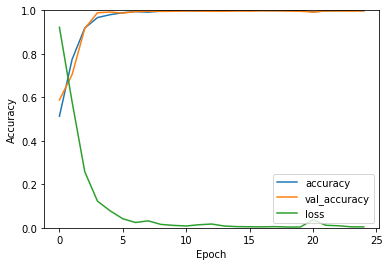

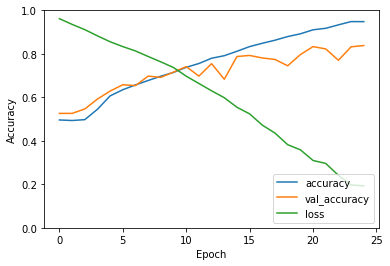

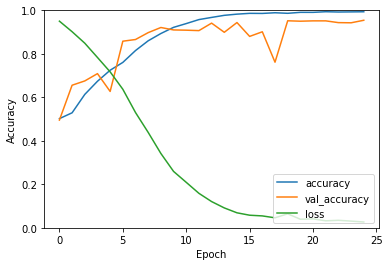

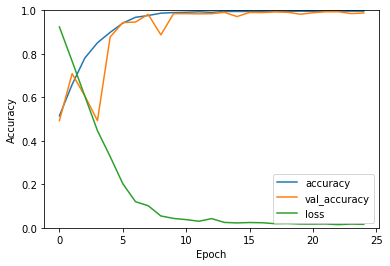

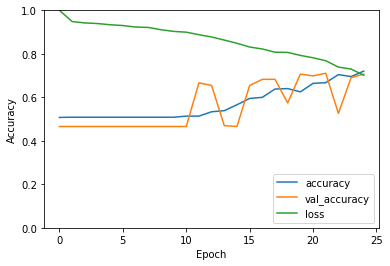

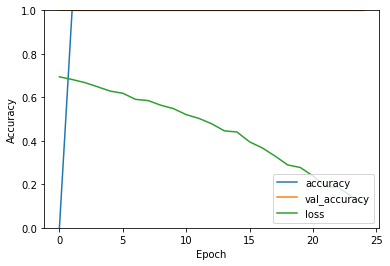

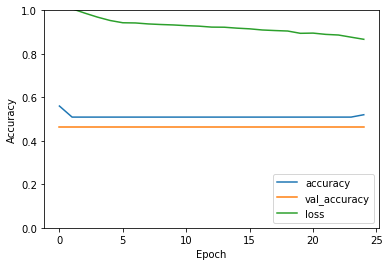

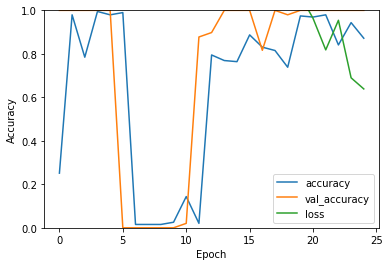

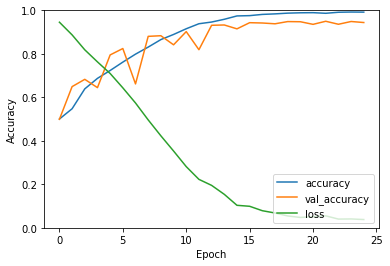

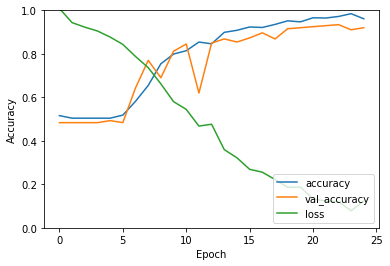

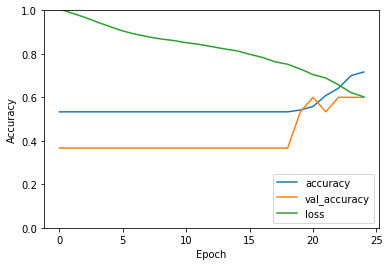

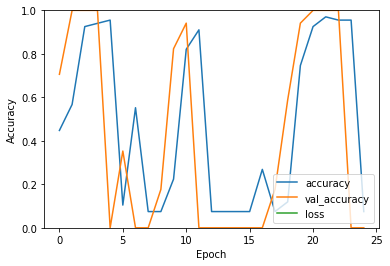

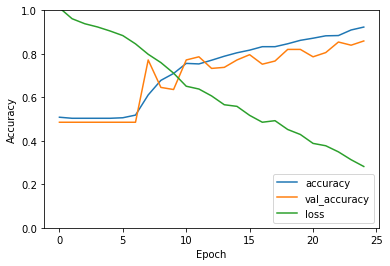

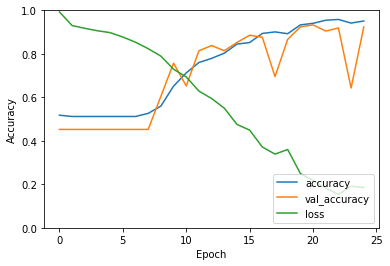

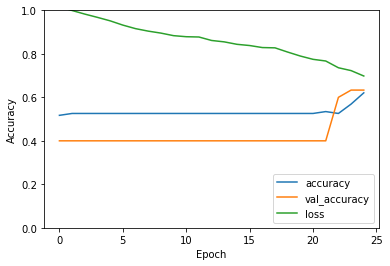

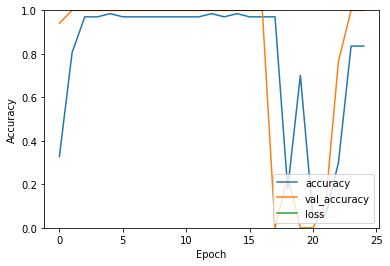

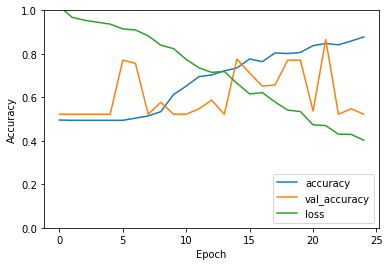

In [5]:
plt_count = 1

for assay, name in zip(dfs, assays):
    print("Training for", name)

    fingerprints = dict()
    bad_smiles = []

    def get_fingerprint(row):
        try:
            sm = smiles.loc[row.name]
            mol = Chem.MolFromSmiles(sm.smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2) #, nBits=1024) # TODO: can replace morgan with other fingerprint!
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints[row.name] = arr
        except Exception as e:
            print("Bad smiles string for", row.name)
            bad_smiles.append(row.name)

    assay.apply(lambda x: get_fingerprint(x), axis=1)

    print("ok:", len(fingerprints.keys()))
    print("bad:", bad_smiles)
    print("bad count:", len(bad_smiles))

    assay.drop(bad_smiles, inplace=True)

    inputs = pd.DataFrame.from_dict(fingerprints, orient="index")
    X = inputs.values.reshape(-1, 2048)
    y = assay.values

    oversample = imblearn.over_sampling.SMOTE()
    try:
        X, y = oversample.fit_resample(X, y)
    except Exception as e:
        print("Oversampling not possible")
        print(e)

    X = X.reshape(-1, 2048, 1)
    y = y.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Conv1D(32, 16, activation='relu', input_shape=(2048, 1)))
    model.add(MaxPool1D())
    model.add(Conv1D(64, 32, activation='relu'))
    model.add(MaxPool1D())
    model.add(Conv1D(128, 16, activation='relu'))
    model.add(Flatten())
    model.add(Dense(units=2048, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1024, activation='relu'))
    model.add(Dense(units=y.shape[1], activation='sigmoid'))

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=['accuracy'],
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

    class_weight = {0: 1.,
                    1: float(len(X_train) / sum(y_train))}

    history = model.fit(
        X_train, y_train, epochs=25, verbose=1, validation_data=(X_test, y_test), class_weight=class_weight,
    )

    plt.figure(plt_count)
    plt_count += 1
    
    plt.plot(history.history["accuracy"], label='accuracy')
    plt.plot(history.history["val_accuracy"], label='val_accuracy')
    plt.plot(history.history["loss"], label='loss')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.0, 1])
    plt.legend(loc='lower right')

    vacc = max(history.history["val_accuracy"])
    acc = max(history.history["accuracy"])

    print(acc, vacc)

    model.save(f"models/sac/nn_{name}.h5")
    plt.savefig(f"models/sac/train_{name}_{acc}_{vacc}.png")
    print("model saved", name)